# Predicting Property Values
### Zillow Regression Project

by DeAngelo Bowen 2022-06-08

---

# Project Overview

## Description : 

Provide insights and any potential improvements to the Zillow Data Science Team's, 2017 Single Family Property prediction model. 

## Project Goals : 

- Construct a ML Regression model that can predict property tax value ('tax_value') of single family homes in 2017. 
- Find Key drivers of property tax value for single family homes.
- Make recommendations on what works or what might not work given evaluation in prediction of the homes' values.

### Project/Executive Summary:
- The purpose of this project is to create a more accurate model than the Data Science Team currently has. 
- To do this, I properly prepared data from our mySQL server, and made changes that would accurately represent the data but not harm the integrity of the data. 
- I then created visualizations that represent specific observations of the data.
- Finally, I created multiple models-- all that performed better than our current model, of which a Polynomial Regression model performed best both with both data it had been trained on, and foreign data. 
- The biggest takeaway while observing this report is that while there are many features in this dataset that may slightly influence total property value, there is no one true definer. 
- My recommendation to try and improve upon that is to collect different aspects of new data, such as the age of a home or any upgrades the house has had over the years, to potentially better represent the current total property value of homes today. 

---

---

## Imports Implemented : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import acquire as aq
import prepare as pr
import explore as ex
import wrangle as wr
import math


from itertools import combinations
from scipy import stats
from scipy.stats import pearsonr, spearmanr

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

warnings.filterwarnings('ignore')

---

## Preparing the data :

To acquire the data, I use the zillow database in CodeUp's mySQL. The following code used was to acquire all pertinent information regarding purchases made in 2017 that were single family homes: 

> ```python
SELECT bathroomcnt, bedroomcnt, taxvaluedollarcnt, taxamount,
        calculatedfinishedsquarefeet, yearbuilt, fips
        FROM properties_2017 
        LEFT JOIN predictions_2017 USING (parcelid) 
        LEFT JOIN propertylandusetype USING (propertylandusetypeid)
        WHERE propertylandusedesc IN ('Single Family Residential',
        'Inferred Single Family Residential') 
        AND YEAR(transactiondate) = 2017;
```

### Resulting in : 
- 52441 Rows returned
- 7 Columns returns
- A lot that needed to be cleaned 

### Final Preparations of the data : 

### After cleaning the data : 
- Null values have been dropped, removing about 8k homes from the dataset
- Accurately represented the 'fips' column
- Column naming conventions were changed for more readable and recognizable content
- Bedroms and bathroom outliers were changed where bedrooms or bathrooms would equal 0, as these are not representitive of a family home as outlined : [CHAPTER 96. - SINGLE- AND MULTI-FAMILY HOUSING CODE, of the Code of Ordinances](https://library.municode.com/tx/carrollton/codes/code_of_ordinances?nodeId=TITIXHESAPRMA_CH96SIULMIHOCO)

# Data Dictionary
>|Column | Description | Dtype|
|--------- | --------- | ----------- |
|bathrooms| number of bathrooms| float64|
|bedrooms| number of bedrooms| int64|
|tax_value| final home estimated price| int64|
|tax_amount| amount of taxes| float64|
|fips| county location| String|
|sqft| home sqare feet| int64|
|year_built| home year was built| int64|

## Understanding Fips:
- Fips is the county code associated with each state. 

### 06 = California
- 037 = Los Angeles
- 059 = Orange County 
- 111 = Ventura County

[Click here for the full list of all State and County codes](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)

### Resulting in : 
- 44581 Columns
- 7 Rows
- Much cleaner dataset

### Moving into Exploration : 
- To go into exploration I must split the data into 3 different datasets (train, validate, and test)
- This will allow me to ***validate*** that my models are not overfit
- It finally allows me to ***test*** my model on unseen data for potential future use.

In [2]:
# acquiring the data
df = aq.get_zillow_data()

# initial preparation of the data before splitting
zillow = pr.prep_zillow_initial(df)

# splitting the data
train, validate, test = pr.prep_zillow(df)

---

## Exploratory Analysis :
- To analyze some of the key features of home value, I looked at the distribution of each o feature by county.

<Figure size 720x936 with 0 Axes>

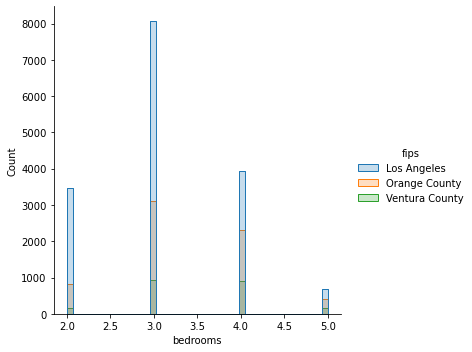

<Figure size 720x936 with 0 Axes>

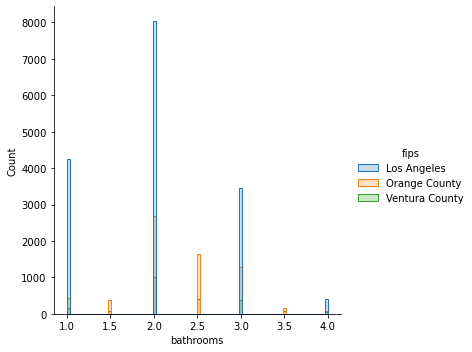

<Figure size 720x936 with 0 Axes>

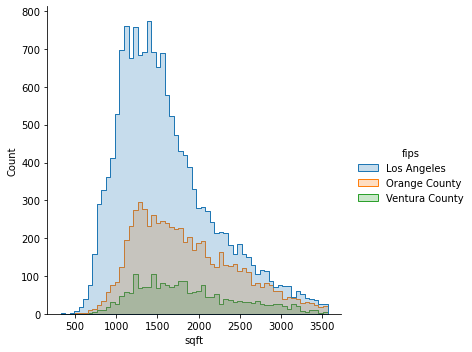

<Figure size 720x936 with 0 Axes>

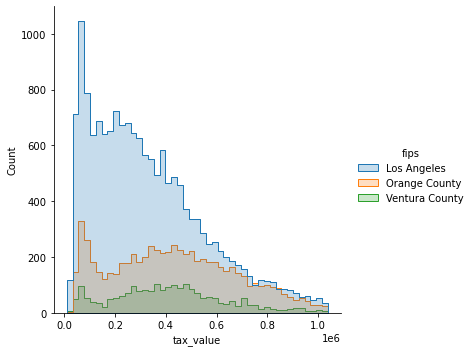

In [3]:
ex.plot_categorical_and_continuous_vars_displot(train)

### Takeaways : 
- This allowed me to identify where most of the data was coming from, which lead to questions that could be related to assessing home value. 

### Exploratory Analysis Summary : 
- Los Anageles had the largest distribution of data. 
- The 'tax_amount' column was a function of the 'tax_value' or total property value, and as such would not be recommended for modeling or performing statistical tests on.
- sqaurefoot 'sqft' has the highest correlation with tax value amount (.42 or 42%)

---

## Exploratory Questions:

### How can we determine home value?  

### Question 1 : Are certain counties more expensive/ have a higher tax value on average than others?

<Figure size 864x576 with 0 Axes>

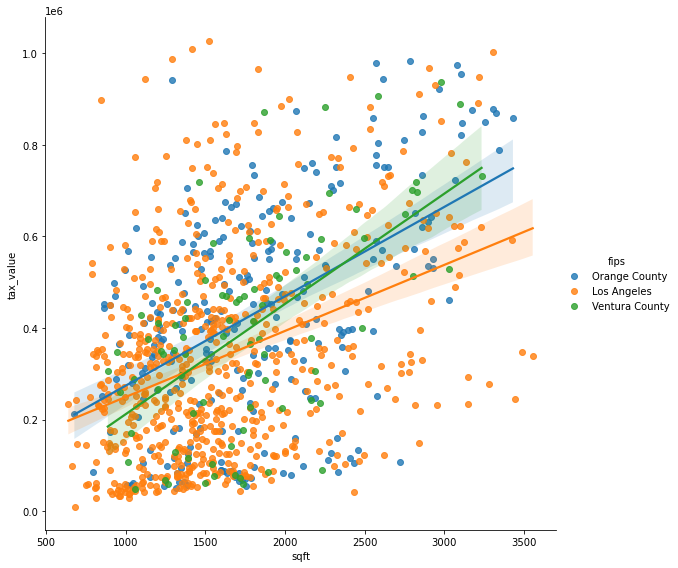

In [4]:
ex.zillow_lmplot(train)

### Takeaways : 
- Los Angeles has, on average, cheaper total home value than Ventura and Orange County, which is seen by looking at the regression lines. 
- Ventura and Orange County are closer to one another in terms of average value. 

### Question 2 :  Why are some properties valued so differently from others when they are located so close to each other?

- To do this, I targeted the homes in Orange County, as the homes in the same county would be the best representation of being 'close to each other'

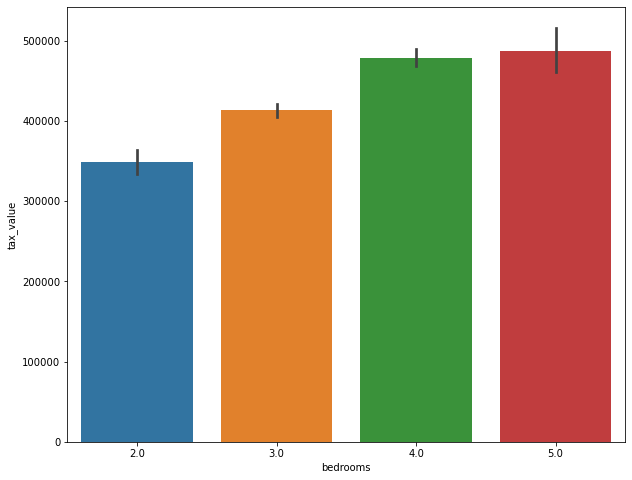

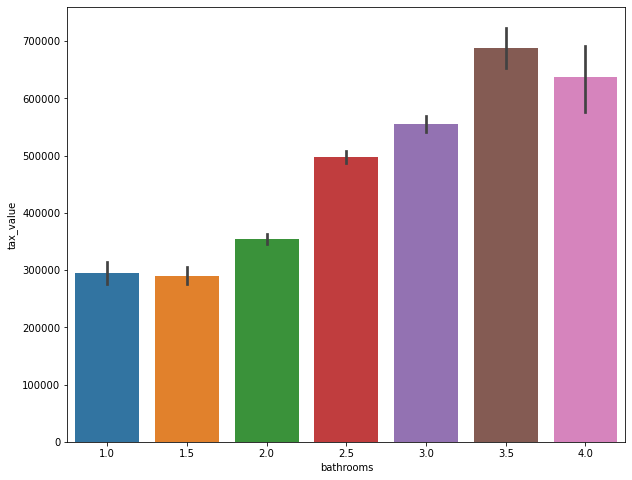

In [5]:
ex.get_orange_county_data(train)

## Takeaways : 
- The more features in, or added to a home, the higher the total home value.

### Question 3: Is having 1 Bathroom  worse than have 2 Bathrooms? 
- The distribution of bathrooms in this dataset being favored to 2 hints at 2 bathrooms being the better choice. Let's see why : 

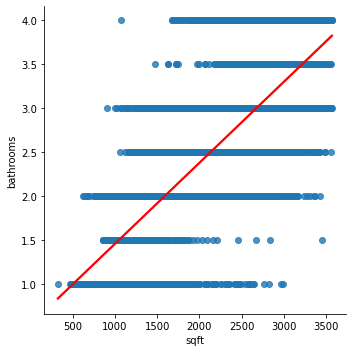

In [6]:
ex.bathroom_lmplot(train)

## Takeaways and Further Analysis : 
- Homes with 2 bathrooms took up 46% of the data, but...
- Cost $64,214 in total home value more than 1 bedroom, however...
- On average was 500 sqare feet larger than homes with 1 bathroom.
- The idea is that MORE space is BETTER so, let's see if they truly have a relationship

- ${H_0}$ : My null hypothesis is that there is no linear correlation between square feet and number of bathrooms and that they are independent. 
- ${H_a}$ : My alternative hypothesis is that there is a linear correlation.

In [7]:
ex.bathroom_ttest(train)

I reject the null hypothesis that there is no linear correlation between square feet and number of bedrooms. 


### Question 4: Is there a relationship between the year a home was built and it's value? 

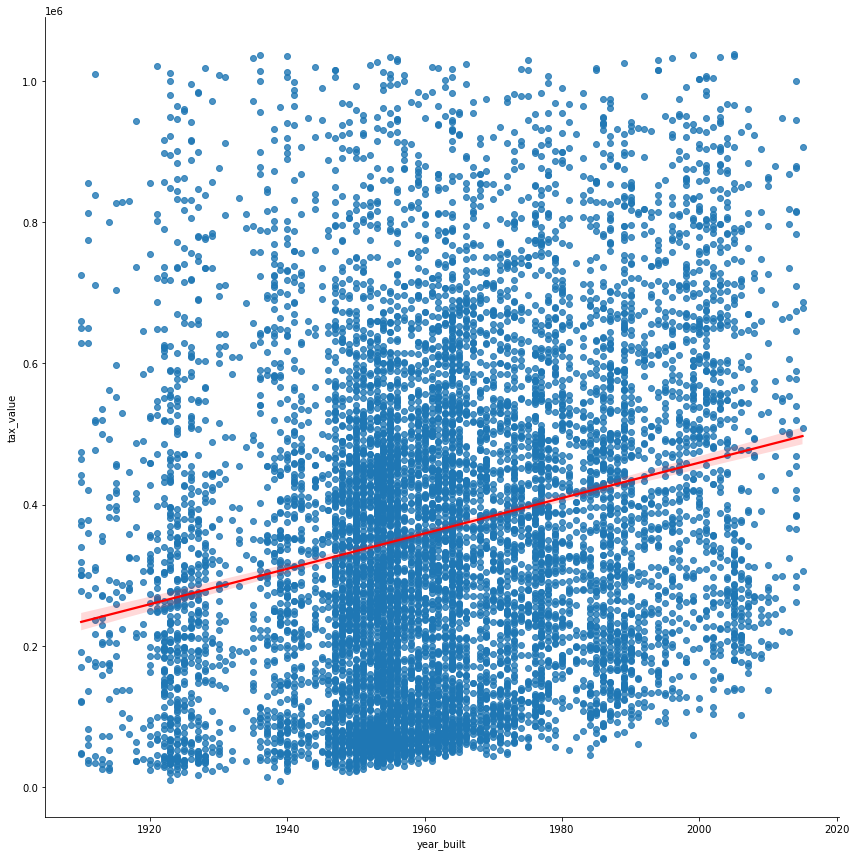

In [8]:
ex.year_and_value(train)

- ${H_0}$ : My null hypothesis is that there is no linear correlation between year built and tax value and that they are independent. 
- ${H_a}$ : My alternative hypothesis is that there is a linear correlation.

In [9]:
ex.year_ttest(train)

I reject the null hypothesis that there is no linear correlation between total home value and the year the home was built.


### Takeaways :
- There is a linear relationship between the year built and the price of the home.
- So, while majority of homes were built in the 1950s, the newer the home, the higher the tax value.

### Exploratory Questions Summary:
- #### Question 1 : Are certain counties more expensive/ have a higher tax value on average than others?
    - Yes, Ventura and Orange County are on average more expensive than Los Angeles. 
- #### Question 2 : Why are some properties valued so differently from others when they are located so close to each other?
    - Because the amount of features influence the total property value. 
- #### Question 3 : Question 3: Is having 1 Bathroom  worse than have 2 Bathrooms? 
    - Having 1 bedroom is better for price, but much worse for sqare feet.
- #### Question 4 : Question 4: Is there a relationship between the year a home was built and its' value? 
    - Yes, there is a linear correlation wiith the year a home was built and its' value.

---

# Modeling

### Pre-modeling:
- Before modeling the data, I observed the distribution the data using a MinMaxScaler :

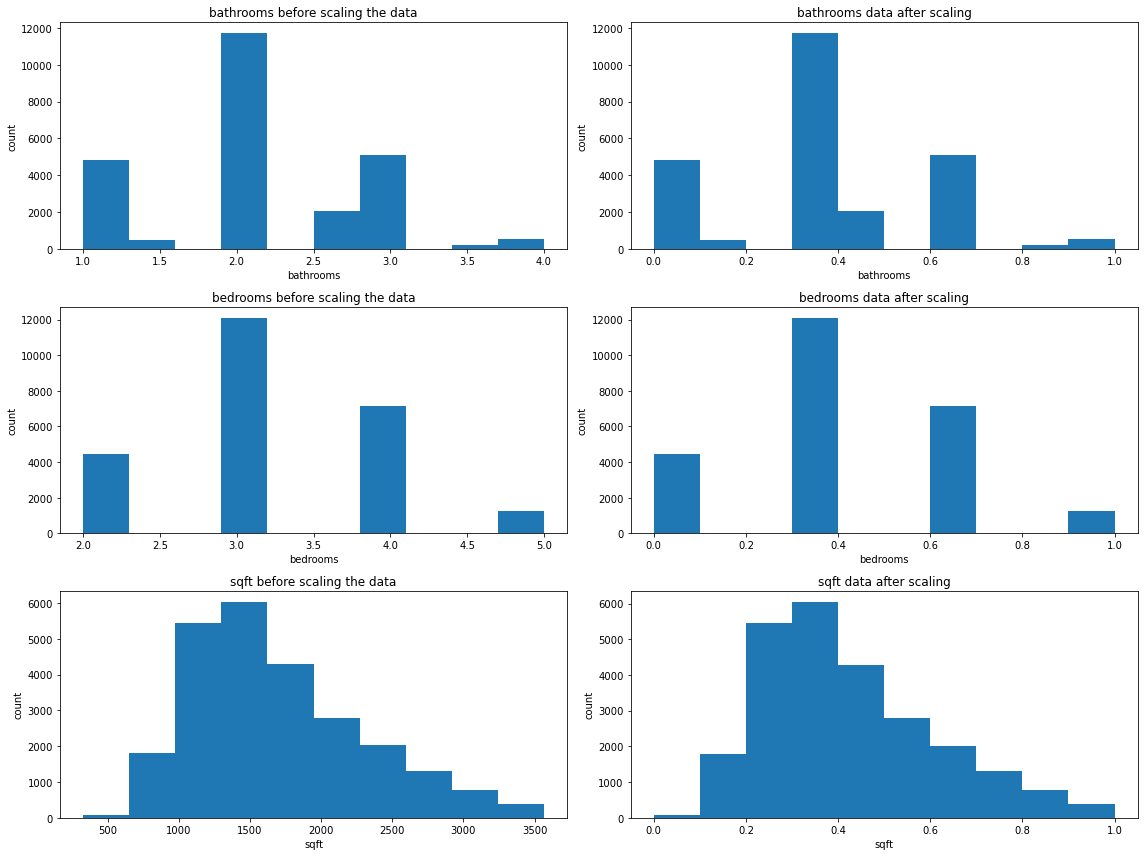

(<Figure size 1152x864 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bathrooms before scaling the data'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms data after scaling'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bedrooms before scaling the data'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms data after scaling'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'sqft before scaling the data'}, xlabel='sqft', ylabel='count'>,
         <AxesSubplot:title={'center':'sqft data after scaling'}, xlabel='sqft', ylabel='count'>]],
       dtype=object))

In [10]:
ex.visualize_scaler(scaler=MinMaxScaler(), df=train, target = ['bathrooms',
                                                            'bedrooms',
                                                            'sqft'])

### Takeaways:
- Columns look evenly distributed, so the MinMaxScaler was a solid choice.
- Moving forward I should scale the data. 

In [11]:
train_scaled, validate_scaled, test_scaled = wr.scale_data(train, validate, test)

### Final Preparations for scaling and modeling : 

Creating X and Y groups for modeling:

In [12]:
# create X and Y groups for modeling
X_train, y_train = train_scaled.drop(columns=['tax_value', 'fips', 'year_built']), train_scaled.tax_value
X_validate, y_validate = validate_scaled.drop(columns=['tax_value', 'fips','year_built']), validate_scaled.tax_value
X_test, y_test = test_scaled.drop(columns=['tax_value', 'fips','year_built']), test_scaled.tax_value

Setting up and calculating for the baseline accuracy:

In [13]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

pred_train = y_train.copy()
pred_train = pred_train.rename(columns = {'tax_value': 'actual_value'})

pred_validate = y_validate.copy()
pred_validate = pred_validate.rename(columns = {'tax_value': 'actual_value'})

pred_test = y_test.copy()
pred_test = pred_test.rename(columns = {'tax_value': 'actual_value'})

# calculate baseline mean and baseline predictions
pred_train['baseline_mean'] = y_train.tax_value.mean()
pred_validate['baseline_mean'] = y_train.tax_value.mean()
pred_test['baseline_mean'] = y_test.tax_value.mean()

# calculate baseline median
pred_train['baseline_median'] = y_train.tax_value.median()
pred_validate['baseline_median'] = y_train.tax_value.median()
pred_test['baseline_median'] = y_test.tax_value.median()

Finally, calculating the Root Mean Square Error to test against the models: 

In [14]:
# RMSE of baseline mean
rmse_train = mean_squared_error(pred_train.actual_value,
                                pred_train.baseline_mean)**(1/2)

rmse_validate = mean_squared_error(pred_validate.actual_value,
                                   pred_validate.baseline_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

print(' ')
print('----------------------------------------------------------')
print(' ')

# RMSE of baseline median
rmse_train = mean_squared_error(pred_train.actual_value,
                                pred_train.baseline_median)**(1/2)

rmse_validate = mean_squared_error(pred_validate.actual_value,
                                   pred_validate.baseline_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  234552.3 
Validate/Out-of-Sample:  233189.25
 
----------------------------------------------------------
 
RMSE using Median
Train/In-Sample:  236904.68 
Validate/Out-of-Sample:  235981.09


### The lower the RMSE, the more predicitve the model. As such we will use __ as our baseline.

# Model Performace: 
#### For the MVP I trained and fit the following 4 models:
- Model 1 - Ordinary Least Squares Model
- Model 2 - Tweedie Regressor Model (Power=1, Alpha=4)
- Model 3 - Polynomial Regression Model
- Model 4 - Lasso Lars Model

### The following is the documentation and code for those models:


## OLS

In [15]:
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train)

pred_train['ols'] = lm.predict(X_train)
pred_validate['ols'] = lm.predict(X_validate)


rmse_train1 = mean_squared_error(pred_train.actual_value,
                                pred_train.ols)**(1/2)

rmse_validate1 = mean_squared_error(pred_validate.actual_value,
                                pred_validate.ols)**(1/2)

## Tweedie Regressor 

In [16]:
# create the model object
glm = TweedieRegressor(power=1, alpha=4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train)

# predict train
pred_train['glm'] = glm.predict(X_train)
pred_validate['glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_train2 = mean_squared_error(pred_train.actual_value, pred_train.glm)**(1/2)

# evaluate: rmse
rmse_validate2 = mean_squared_error(pred_validate.actual_value, pred_validate.glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=4\nTraining/In-Sample: ", rmse_train2, 
      "\nValidation/Out-of-Sample: ", rmse_validate2)

RMSE for GLM using Tweedie, power=1 & alpha=4
Training/In-Sample:  209663.51673456634 
Validation/Out-of-Sample:  212082.9282108506


## Polynomial Regression

In [17]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train)

# predict train
pred_train['lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train3 = mean_squared_error(pred_train.actual_value, pred_train.lm2)**(1/2)

# predict validate
pred_validate['lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate3 = mean_squared_error(pred_validate.actual_value, pred_validate.lm2)**(1/2)

### Lasso + Lars 

In [18]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train)

# predict 
pred_train['lars'] = lars.predict(X_train)
pred_validate['lars'] = lars.predict(X_validate)


# evaluate: rmse
rmse_train4 = mean_squared_error(pred_train.actual_value, pred_train.lars)**(1/2)

# evaluate: rmse
rmse_validate4 = mean_squared_error(pred_validate.actual_value, pred_validate.lars)**(1/2)

## Key Takeaway:
- #### ALL models performed better than the baseline model with the Polynomial Regression model having the lowest RMSE for both sampled data, thus it was chosen as the best model.

### Evaluating the Polynomial Regression Model on New data (Test-data):

In [19]:
# predict on test
pred_test['lms'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(pred_test.actual_value, pred_test.lms)**(1/2)

print("RMSE for Polynomial Regression using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Polynomial Regression using LinearRegression
Out-of-Sample Performance:  207697.06752286284


### Visualization of Performance: 

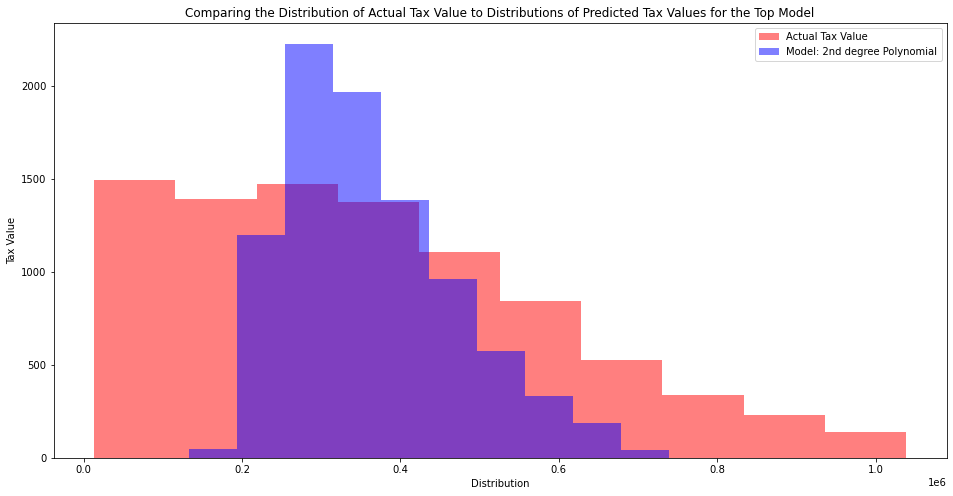

In [20]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(pred_test.actual_value, color='red', alpha=.5, label="Actual Tax Value")
plt.hist(pred_test.lms, color='blue', alpha=.5, label="Model: 2nd degree Polynomial")
plt.xlabel("Distribution")
plt.ylabel("Tax Value")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Values for the Top Model")
plt.legend()
plt.show()

# In Conclusion:

## Results of Obeserving the Primary Goals:

#### Constructed a ML Regression model that can predict property tax value of single family homes in 2017. 
   - My Polynomial Regression Model beat the baseline model and had outstanding performace over the other models. 
   - Increased accuracy by ~20%

#### Find Key drivers of property tax value for single family homes.
   - Having more bathrooms increased the value of a property
   - Having more squarefeet increased the value of a property
   - The newer the property, the more the value increases
   - Location is a driver in total property value

## Recommendations: 

- Continue analyzing these key drivers in predicting total home value over time and making improvements to data collection.
- Integrate additional features into the dataset that may help accurately define a feature that influences total home value (i.e. age of home and upgrades). 

### Next Steps - with more time: 

- Evaluate on more unique models
- Investigate the data further-- assuming there is potential data to be collected that can further accurately predict a homes value. 
- Compare this dataset with a more recent housing dataset to see if more features arise that can accurately predict value.
- Dive deeper into observing county by county and seeing if there are more specific trends located to counties that drive property value.